In [11]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from scipy.sparse import coo_matrix,csr_matrix
from anndata import AnnData
from sklearn.neighbors import KDTree
import re


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

# spatial AS code

In [7]:
def change_as_id(x,chrom_change):
    chrom,s,e = x.split(':')
    chrom = chrom_change[chrom]
    return f"{chrom}:{s}:{e}"

    
def load_adata(intron_matrix,sample,stereo):
    psi_adata = sc.read_10x_mtx(intron_matrix,gex_only=False,cache=True)
    psi_adata.var_names.name = 'gene_ids'
    if stereo:
        psi_adata.obs['coor'] = psi_adata.obs_names
        try:
            psi_adata.obs[['x','y']] = psi_adata.obs['coor'].str.split('_',expand=True).astype(int)
        except:
            psi_adata.obs['x'] = psi_adata.obs['coor'].map(lambda x : x.split('_')[1])
            psi_adata.obs['y'] = psi_adata.obs['coor'].map(lambda x : x.split('_')[2])
        psi_adata.obsm['spatial'] = psi_adata.obs[['x','y']].values
        psi_adata.obs_names = sample + "_"+ psi_adata.obs_names
        psi_adata.obs['sample'] = sample
    return psi_adata

def load_intron(intron_matrix,ri_matrix,sample,min_cells = 1,min_expression = 10,stereo = True):
    psi_adata = load_adata(intron_matrix,sample,stereo)
    raw_intron_count = psi_adata.shape[1]
    sc.pp.filter_genes(psi_adata,min_cells = min_cells)
    intron_count = psi_adata.shape[1]
    print(f'Find intron in raw matrix : {raw_intron_count}')
    print(f'Remain intron count > {min_cells} cells: {intron_count}')
    psi_adata.var['chrom'] = psi_adata.var['gene_ids'].apply(lambda x : x.split(':')[0])
    chrom_change = {}
    change_id = False
    for chrom in psi_adata.var['chrom'].drop_duplicates():
        if chrom.isdigit():
            change_id = True
            chrom_change[chrom] = f'chr{chrom}'
        elif chrom == 'MT':
            chrom_change[chrom] = 'chrM'
        elif chrom == 'Y' or chrom == 'X':
            chrom_change[chrom] = f'chr{chrom}'
        else:
            chrom_change[chrom] = chrom

    psi_adata.var['expression'] = np.sum(psi_adata.X,axis = 0).reshape(-1,1)
    psi_adata = psi_adata[:,psi_adata.var['expression'] >= min_expression].copy()
    print(f'Remain intron count > {min_cells} expression: {psi_adata.shape[1]}')
    if change_id:
        psi_adata.var['gene_ids'] = psi_adata.var['gene_ids'].apply(lambda x :change_as_id(x,chrom_change))
        psi_adata.var_names = psi_adata.var['gene_ids']

    psi_adata.var[['chrom','start','end_strand']] = psi_adata.var['gene_ids'].str.split(':',expand=True)
    psi_adata.var['end'] = psi_adata.var['end_strand'].apply(lambda x : x[:-1])
    psi_adata.var['strand'] = psi_adata.var['end_strand'].apply(lambda x : x[-1])
    del psi_adata.var['end_strand']

    # load RI
    tmp_ri_adata = load_adata(ri_matrix,sample,stereo = stereo)
    all_barcode = set(psi_adata.obs_names)
    ri_barcode = set(tmp_ri_adata.obs_names)
    ri_barcode = all_barcode.intersection(ri_barcode)
    need_barcode = all_barcode - ri_barcode
    tmp_ri_adata = tmp_ri_adata[tmp_ri_adata.obs_names.isin(ri_barcode)]
    need_adata = psi_adata[psi_adata.obs_names.isin(need_barcode)]
    empty = AnnData(csr_matrix(need_adata.shape))
    empty.obs_names = need_adata.obs_names
    empty.var_names = need_adata.var_names
    ri_adata = sc.concat([tmp_ri_adata,empty])

    return psi_adata,ri_adata

In [8]:
def tranid2event(tranid):
    chrom = tranid.split(':')[0]
    chrom = chrom.split('chr')[1]
    pattern = ''.join(re.findall(r'[@|]', tranid))
    if pattern == '@@':  # SE
        event = 'SE'
    elif pattern == '@@@':   # MXE
        event = 'MXE'
    elif pattern == '|@': # A5SS
        event = 'A5SS'
    elif pattern == '@|': # A3SS
        event = 'A3SS'
    elif pattern == '@': # RI
        event = 'RI'
    return event

def extract_SE(transid,strand):
    if strand:
        up,mid,down = transid.split(':+@')
    else:
        down,mid,up = transid.split(':-@')
    _,upstreamES,upstreamEE = up.split(':')
    _,downstreamES,downstreamEE = down.split(':')
    _,skexon_start,skexon_end = mid.split(':')
    return [(upstreamEE,skexon_start),(skexon_end,downstreamES),(upstreamEE,downstreamES)]

def extract_MXE(transid,strand):   # ex1  ex1  ex2 ex2
    if strand:
        up,ex1,ex2,down = transid.split(':+@')
    else:
        down,ex2,ex1,up = transid.split(':-@')
        
    _,upstreamES,upstreamEE = up.split(':')
    _,downstreamES,downstreamEE = down.split(':')
    _,E1S,E1E = ex1.split(':')
    _,E2S,E2E = ex2.split(':')
    return [(upstreamEE,E1S),(E1E,downstreamES),(upstreamEE,E2S),(E2E,downstreamES)]
    
        
def extract_A5SS(transid,strand):    # short long
    if strand:
        up,down = transid.split(':+@')
        shortEE,longExonEnd = up.split(':')[2].split('|')
        chrom,flankingES,flankingEE=down.split(':')
        return [(longExonEnd,flankingES),(shortEE,flankingES)]
    else:
        up,down = transid.split(':-@')
        longExonStart,shortES=up.split(':')[2].split('|')
        chrom,flankingES,flankingEE=down.split(':')
        return [(flankingEE,longExonStart),(flankingEE,shortES)]
    
def extract_A3SS(transid,strand):  # short,long
    if strand:
        up,down = transid.split(':+@')
        chrom,flankingES,flankingEE=up.split(':')
        longExonStart=down.split(':')[1].split('|')[0]
        shortES = down.split(':')[1].split('|')[1]
        return [(flankingEE,longExonStart),(flankingEE,shortES)]
    else:
        up,down = transid.split(':-@')
        chrom=up.split(':')[0]
        flankingES=up.split(':')[1]
        shortEE,longExonEnd=down.split(':')[1].split('|')
        return [(longExonEnd,flankingES),(shortEE,flankingES)]
    
    
def extract_RI(transid,strand): 
    if strand:
        up,down = transid.split(':+@')
    else:
        down,up = transid.split(':-@')
    chrom,upES,upEE = up.split(':') 
    chrom,downES,downEE = down.split(':')
    return [(upEE,downES)]

def strand_define(transid,return_sig = True):
    if return_sig:
        if '+' in transid:
            return True
        elif '-' in transid:
            return False
    else:
        if '+' in transid:
            return '+'
        elif '-' in transid:
            return '-'

def tranid2intron_unverified(transid,return_event = False):
    chrom = transid.split(':')[0]
    pattern = ''.join(re.findall(r'[@|]', transid))
    strand = strand_define(transid)
    strand_sig = strand_define(transid,return_sig = False)
    if pattern == '@@':  # SE
        event = 'SE'
        intron_list = extract_SE(transid,strand)
        
    elif pattern == '@@@':   # MXE
        event = 'MXE'
        intron_list = extract_MXE(transid,strand)
        
    elif pattern == '|@': # A5SS
        event = 'A5SS'
        intron_list = extract_A5SS(transid,strand)
    elif pattern == '@|': # A3SS
        event = 'A3SS'
        intron_list = extract_A3SS(transid,strand)
    elif pattern == '@': #RI
        event = 'RI'
        intron_list = extract_RI(transid,strand)
    
    
    intron_name_list = []
    for intron in intron_list:
        intron_name = chrom + ":" + str(int(intron[0])) + ":" + str(int(intron[1])) + strand_sig
        intron_name_list.append(intron_name)
    
    if return_event:
        return event,intron_name_list
    else:
        return intron_name_list
    

def row_has_duplicates(row):
    return len(row) == len(set(row))
    
def se_func(rmats_se):
    def transform_row(x):
        if x["strand"] == "+":
            tran = f"{x['chr']}:{x['upstreamES']}:{x['upstreamEE']}:+@{x['chr']}:{x['exonStart_0base']}:{x['exonEnd']}:+@{x['chr']}:{x['downstreamES']}:{x['downstreamEE']}"
        else:
            tran = f"{x['chr']}:{x['downstreamES']}:{x['downstreamEE']}:-@{x['chr']}:{x['exonStart_0base']}:{x['exonEnd']}:-@{x['chr']}:{x['upstreamES']}:{x['upstreamEE']}"
        return tran
    rmats_se['tran_id'] = rmats_se.apply(transform_row, axis=1)
    return rmats_se

# MXE
def mxe_func(rmats_mxe):
    def transform_row(x):
        if x["strand"] == "+":
            tran = f"{x['chr']}:{x['upstreamES']}:{x['upstreamEE']}:+@{x['chr']}:{x['1stExonStart_0base']}:{x['1stExonEnd']}:+@{x['chr']}:{x['2ndExonStart_0base']}:{x['2ndExonEnd']}:+@{x['chr']}:{x['downstreamES']}:{x['downstreamEE']}"
        else:
            tran = f"{x['chr']}:{x['downstreamES']}:{x['downstreamEE']}:-@{x['chr']}:{x['2ndExonStart_0base']}:{x['2ndExonEnd']}:-@{x['chr']}:{x['1stExonStart_0base']}:{x['1stExonEnd']}:-@{x['chr']}:{x['upstreamES']}:{x['upstreamEE']}"
        return tran
    rmats_mxe['tran_id'] = rmats_mxe.apply(transform_row, axis=1)
    return rmats_mxe

# A5SS
def a5ss_func(rmats_a5ss):
    def transform_row(x):
        if x["strand"] == "+":
            tran = f"{x['chr']}:{x['longExonStart_0base']}:{x['shortEE']}|{x['longExonEnd']}:+@{x['chr']}:{x['flankingES']}:{x['flankingEE']}"
        else:
            tran = f"{x['chr']}:{x['longExonEnd']}:{x['longExonStart_0base']}|{x['shortES']}:-@{x['chr']}:{x['flankingES']}:{x['flankingEE']}"
        return tran

    rmats_a5ss['tran_id'] = rmats_a5ss.apply(transform_row, axis=1)
    return rmats_a5ss

# A3SS
def a3ss_func(rmats_a3ss):
    def transform_row(x):
        if x["strand"] == "+":
            tran = f"{x['chr']}:{x['flankingES']}:{x['flankingEE']}:+@{x['chr']}:{x['longExonStart_0base']}|{x['shortES']}:{x['longExonEnd']}"
        else:
            tran = f"{x['chr']}:{x['flankingES']}:{x['flankingEE']}:-@{x['chr']}:{x['shortEE']}|{x['longExonEnd']}:{x['longExonStart_0base']}"
        return tran

    rmats_a3ss['tran_id'] = rmats_a3ss.apply(transform_row, axis=1)
    return rmats_a3ss

def ri_func(rmats_ri):
    def transform_row(x):
        if x["strand"] == "+":
            tran = f"{x['chr']}:{x['upstreamES']}:{x['upstreamEE']}:+@{x['chr']}:{x['downstreamES']}:{x['downstreamEE']}"
        else:
            tran = f"{x['chr']}:{x['downstreamEE']}:{x['downstreamES']}:-@{x['chr']}:{x['upstreamEE']}:{x['upstreamES']}"
        return tran

    rmats_ri['tran_id'] = rmats_ri.apply(transform_row, axis=1)
    return rmats_ri



def combine_columns(row, sep='_'):
    return sep.join(row.astype(str))

def intron_check(tran_id_df,remain_intron,event,allow_missing = False):
    tran_jug = tran_id_df.isin(remain_intron)
    if allow_missing:
        if event == 'SE':
            allow_tran_id = tran_jug[tran_jug['i3'] & (tran_jug['i1'] | tran_jug['i2'])].index
            tran_id_df = tran_id_df.loc[allow_tran_id].copy()
        elif event == 'MXE':
            allow_tran_id = tran_jug[tran_jug['i2'] | tran_jug['i3']].index
            tran_id_df = tran_id_df.loc[allow_tran_id].copy()
        elif event == 'A3SS' or event == 'A5SS':
            allow_tran_id = tran_jug[tran_jug['i1'] & tran_jug['i2']].index
            tran_id_df = tran_id_df[np.sum(tran_jug,axis = 1) == tran_id_df.shape[1]].copy()
        elif event == 'RI':
            tran_id_df = tran_id_df[np.sum(tran_jug,axis = 1) == tran_id_df.shape[1]].copy()
    else:
        tran_id_df = tran_id_df[np.sum(tran_jug,axis = 1) == tran_id_df.shape[1]].copy()
        
    tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
    check_id = tran_id_df.copy()
    check_id['replace_id'] = check_id.apply(combine_columns,axis = 1)
    if event =='A3SS' or event == 'A5SS':
        only_ass = check_id[['i1','i2']]
        check_id = check_id.loc[only_ass[only_ass.apply(row_has_duplicates,axis = 1)].index]
    unique_as_index = check_id.drop_duplicates('replace_id',keep='first').index
    tran_id_df = tran_id_df.loc[unique_as_index].copy()
    return tran_id_df

class as_class:
    def __init__(self,rmats_result):
        self.rmats_result = rmats_result
        self.load_rmats_data()
        self.bulid_intron()
    
    def load_bigwig(self,bigwig):
        self.bigwig = bigwig

    def load_rmats_data(self):
        input_proxy = self.rmats_result
        for event_type in ["SE",'MXE','A3SS','A5SS','RI']:
            file_path = f"{input_proxy}/fromGTF.{event_type}.txt"
            rmats_data = pd.read_csv(file_path, sep='\t')
            if event_type=='SE':
                rmats_data = se_func(rmats_data)
                rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
                self.raw_se = rmats_data                
            elif event_type=='MXE':
                rmats_data = mxe_func(rmats_data)
                rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
                self.raw_mxe = rmats_data
            elif event_type=='A3SS':
                rmats_data = a3ss_func(rmats_data)
                rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
                self.raw_a3ss = rmats_data
            elif event_type=='A5SS':
                rmats_data = a5ss_func(rmats_data)
                rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
                self.raw_a5ss = rmats_data
            elif event_type =='RI':
                rmats_data = ri_func(rmats_data)
                rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
                self.raw_ri = rmats_data


    def select_tranid(self,tranid_list,qcpass=False,scpass=False):
        tmp_se = self.valid_se[self.valid_se['tran_id'].isin(tranid_list)].reset_index(drop=True).copy()
        tmp_mxe = self.valid_mxe[self.valid_mxe['tran_id'].isin(tranid_list)].reset_index(drop=True).copy()
        tmp_a3ss = self.valid_a3ss[self.valid_a3ss['tran_id'].isin(tranid_list)].reset_index(drop=True).copy()
        tmp_a5ss = self.valid_a5ss[self.valid_a5ss['tran_id'].isin(tranid_list)].reset_index(drop=True).copy()
        tmp_ri = self.valid_ri[self.valid_ri['tran_id'].isin(tranid_list)].reset_index(drop=True).copy()
        
        if qcpass:
            print(f'QCpass tran_id:')
            total = 0
            for event,event_df in {'SE':tmp_se,'MXE':tmp_mxe,'A3SS':tmp_a3ss,'A5SS':tmp_a5ss,'RI':tmp_ri}.items():
                print(f'\t{event}:{event_df.shape[0]}')
                total += event_df.shape[0]
            print(f'\tTotal AS event:{total}')
        else:
            total = 0
            for event,event_df in {'SE':tmp_se,'MXE':tmp_mxe,'A3SS':tmp_a3ss,'A5SS':tmp_a5ss,'RI':tmp_ri}.items():
                print(f'\t{event}:{event_df.shape[0]}')
                total += event_df.shape[0]
            print(f'\tTotal AS event:{total}')

        if qcpass:
            self.qcpass_se = tmp_se
            self.qcpass_mxe = tmp_mxe
            self.qcpass_a3ss = tmp_a3ss
            self.qcpass_a5ss = tmp_a5ss
            self.qcpass_ri = tmp_ri
        elif scpass:
            self.scpass_se = tmp_se
            self.scpass_mxe = tmp_mxe
            self.scpass_a3ss = tmp_a3ss
            self.scpass_a5ss = tmp_a5ss
            self.scpass_ri = tmp_ri

    def bulid_intron(self):
        tran_id_se = pd.DataFrame(self.raw_se['tran_id'])
        tran_id_se[['i1','i2','i3']] = tran_id_se['tran_id'].apply(lambda x :tranid2intron_unverified(x)).tolist()
        tran_id_se = tran_id_se.set_index('tran_id')

        tran_id_mxe = pd.DataFrame(self.raw_mxe['tran_id'])
        tran_id_mxe[['i1','i2','i3','i4']] = tran_id_mxe['tran_id'].apply(lambda x :tranid2intron_unverified(x)).tolist()
        tran_id_mxe = tran_id_mxe.set_index('tran_id')

        tran_id_a3ss = pd.DataFrame(self.raw_a3ss['tran_id'])
        tran_id_a3ss[['i1','i2']] = tran_id_a3ss['tran_id'].apply(lambda x :tranid2intron_unverified(x)).tolist()
        tran_id_a3ss = tran_id_a3ss.set_index('tran_id')

        tran_id_a5ss = pd.DataFrame(self.raw_a5ss['tran_id'])
        tran_id_a5ss[['i1','i2']] = tran_id_a5ss['tran_id'].apply(lambda x :tranid2intron_unverified(x)).tolist()
        tran_id_a5ss = tran_id_a5ss.set_index('tran_id')

        tran_id_ri = pd.DataFrame(self.raw_ri['tran_id'])
        tran_id_ri[['i']] = tran_id_ri['tran_id'].apply(lambda x :tranid2intron_unverified(x)).tolist()
        tran_id_ri = tran_id_ri.set_index('tran_id')
        
        intron_list = pd.concat([
                tran_id_se['i1'],tran_id_se['i2'],tran_id_se['i3'],
                tran_id_mxe['i1'],tran_id_mxe['i2'],tran_id_mxe['i3'],tran_id_mxe['i4'],
                tran_id_a3ss['i1'],tran_id_a3ss['i2'],
                tran_id_a5ss['i1'],tran_id_a5ss['i2'],
                tran_id_ri['i']],axis = 0,ignore_index=True).drop_duplicates()
        intron_in_tranid = pd.DataFrame(intron_list,columns=['intron'])
        
        self.intron_df = intron_in_tranid.reset_index(drop=True)
        self.tmp = [tran_id_se,tran_id_mxe,tran_id_a3ss,tran_id_a5ss,tran_id_ri]

    def check_tranid_intron(self,intron_adata,ri_adata,allow_missing = True):
        
        tran_id_se,tran_id_mxe,tran_id_a3ss,tran_id_a5ss,tran_id_ri = self.tmp
        
        remain_intron = intron_adata.var['gene_ids'].tolist()
        
        tran_id_se = intron_check(tran_id_se,remain_intron,event = 'SE',allow_missing = allow_missing)
        tran_id_mxe = intron_check(tran_id_mxe,remain_intron,event = 'MXE',allow_missing = allow_missing)
        tran_id_a3ss = intron_check(tran_id_a3ss,remain_intron,event = 'A3SS',allow_missing = allow_missing)
        tran_id_a5ss = intron_check(tran_id_a5ss,remain_intron,event = 'A5SS',allow_missing = allow_missing)
        tran_id_ri = intron_check(tran_id_ri,remain_intron,event = 'RI',allow_missing = allow_missing)
        tran_id_ri = tran_id_ri[tran_id_ri['i'].isin(ri_adata.var_names)].copy()
        
        self.tmp = [tran_id_se,tran_id_mxe,tran_id_a3ss,tran_id_a5ss,tran_id_ri]
        
        raw_se = self.raw_se
        raw_mxe = self.raw_mxe
        raw_a3ss = self.raw_a3ss
        raw_a5ss = self.raw_a5ss
        raw_ri = self.raw_ri
        self.valid_se = raw_se[raw_se['tran_id'].isin(tran_id_se.index)].copy()
        self.valid_mxe = raw_mxe[raw_mxe['tran_id'].isin(tran_id_mxe.index)].copy()
        self.valid_a3ss = raw_a3ss[raw_a3ss['tran_id'].isin(tran_id_a3ss.index)].copy()
        self.valid_a5ss = raw_a5ss[raw_a5ss['tran_id'].isin(tran_id_a5ss.index)].copy()
        self.valid_ri = raw_ri[raw_ri['tran_id'].isin(tran_id_ri.index)].copy()
        
        print('>> Write valid tran_id in as_meta.valid_xxxx["se","mxe","a3ss","a5ss"] usage: adata.uns["AS"].tranid["*tran_id"]')
    
        se_sum,mxe_sum,a3ss_sum,a5ss_sum,ri_sum = tran_id_se.shape[0],tran_id_mxe.shape[0],tran_id_a3ss.shape[0],tran_id_a5ss.shape[0],tran_id_ri.shape[0]
        print(f"\tSE: {se_sum}\n\tMXE: {mxe_sum}\n\tA3SS: {a3ss_sum}\n\tA5SS: {a5ss_sum}\n\tRI: {ri_sum}\n\tTotal AS event:{se_sum+mxe_sum+a3ss_sum+a5ss_sum+ri_sum}")
        tranid = {}
        for event,df in {"SE":tran_id_se,"MXE":tran_id_mxe,"A3SS":tran_id_a3ss,"A5SS":tran_id_a5ss,'RI':tran_id_ri}.items():
            tmp_dict = df.apply(lambda row: row.tolist(), axis=1).to_dict()
            tranid.update(tmp_dict)
        self.tranid = tranid
    
    def collect_tranid_meta(self,gtf):
        print('Load GTF From GTF ... It takes times')
        gene_info = pd.read_csv(gtf, sep='\t', comment='#', 
                            usecols=[0,2,3,4,8], names=['chr','type','start','end', 'info'],low_memory=False)
        gene_info = gene_info[gene_info['type'] =='gene']
        gene_info['gene_id'] = gene_info['info'].str.extract(r'gene_id "([^"]+)";')
        start_dict = dict(zip(gene_info['gene_id' ],gene_info['start']))
        end_dict = dict(zip(gene_info['gene_id'],gene_info['end']))
        
        tran_meta = {}
        for event,df in {"SE":self.valid_se,"MXE":self.valid_mxe,"A3SS":self.valid_a3ss,"A5SS":self.valid_a5ss,'RI':self.valid_ri}.items():
            df = df.copy()
            df['gene_start'] = df['GeneID'].map(start_dict)
            df['gene_end'] = df['GeneID'].map(end_dict)
            df['gene_len'] = df['gene_end']- df['gene_start']
            if event == 'SE':
                df['event'] = 'SE'
            elif event == 'MXE':
                df['event'] = 'MXE'
            elif event == 'A3SS':
                df['event'] = 'A3SS'
            elif event == 'A5SS':
                df['event'] = 'A5SS'
            elif event == 'RI':
                df['event'] = 'RI'
            sub_tran2gene_and_pos = {tid: [gl,gs,event] for tid,gl, gs, event in zip(df['tran_id'],df['gene_len'], df['geneSymbol'],df['event'])}
            tran_meta.update(sub_tran2gene_and_pos)
        meta_df = pd.DataFrame(tran_meta).T
        meta_df.columns = ['GeneLenth','GeneSymbol','Event']
        self.tranid_meta = meta_df
        self.tran2genelen = dict(zip(meta_df.index,meta_df['GeneLenth']))
        self.tran2gene = dict(zip(meta_df.index,meta_df['GeneSymbol']))
        self.tran2event = dict(zip(meta_df.index,meta_df['Event']))
        print(f">> Save tranid meta info in AS.tranid_meta")
    
def get_intron_df(rmats_result):
    as_meta = as_class(rmats_result)
    intron_df = as_meta.intron_df
    return intron_df
    
def load_as(adata,ri_adata,rmats_result,gtf,allow_missing = True):
    adata.uns['arg'] = {'allow_missing':allow_missing}
    as_meta = as_class(rmats_result)
    as_meta.check_tranid_intron(adata,ri_adata,allow_missing = allow_missing)
    as_meta.collect_tranid_meta(gtf)
    adata.uns['AS'] = as_meta
    print("Write AS in adata.uns['AS']")
    return adata


def read_rmats(rmats_result,keep_FDR = True):
    rmats_df_dict = {}
    input_proxy = rmats_result
    for event_type in ["SE",'MXE','A3SS','A5SS','RI']:
        file_path = f"{input_proxy}/{event_type}.MATS.JC.txt"
        rmats_data = pd.read_csv(file_path, sep='\t')
        if event_type=='SE':
            rmats_data = se_func(rmats_data)
            rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
            rmats_data['exon'] = rmats_data['chr'] + '@' + rmats_data['strand'] + '@' + rmats_data['exonStart_0base'].map(str) + '_' + rmats_data['exonEnd'].map(str)
        elif event_type=='MXE':
            rmats_data = mxe_func(rmats_data)
            rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
            rmats_data['exon'] = rmats_data['chr'] + '@' + rmats_data['strand'] + '@' + rmats_data['1stExonStart_0base'].map(str) + '_' +  rmats_data['1stExonEnd'].map(str) + '@' + rmats_data['2ndExonStart_0base'].map(str) + '_' + rmats_data['2ndExonEnd'].map(str)
        elif event_type=='A3SS':
            rmats_data = a3ss_func(rmats_data)
            rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
            rmats_data['exon'] = rmats_data['tran_id'].map(lambda x :  x.split(':')[0] + '@' + x.split('@')[0].split(':')[-1] + '@'+ '_'.join(x.split('@')[1].split(':')[1].split('|')))

        elif event_type=='A5SS':
            rmats_data = a5ss_func(rmats_data)
            rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
            rmats_data['exon'] = rmats_data['tran_id'].map(lambda x : x.split(':')[0] + '@' + x.split('@')[0].split(':')[-1] + '@' + '_'.join(x.split('@')[0].split(':')[2].split('|')))

        elif event_type =='RI':
            rmats_data = ri_func(rmats_data)
            rmats_data = rmats_data[rmats_data['chr'].isin([f'chr{x}' for x in range(1,23)] + ['chrX','chrY','chrM'])]
            rmats_data['exon'] = rmats_data['chr'] + '@' + rmats_data['strand'] + '@' + rmats_data['upstreamEE'].map(str) + '_' + rmats_data['downstreamES'].map(str)
        if keep_FDR:
            rmats_data = rmats_data[rmats_data['FDR']<=0.05]
        rmats_df_dict[event_type] = rmats_data
    return rmats_df_dict

# load junction data

In [3]:
sample = 'A5'
gtf = "/storage/liuyi/08.stereo_v2/reference/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf"

tvsn_intron_matrix = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/tumor_normal_dup_rmats/as/03.intron/count_bin100'
tvsn_ri_matrix = "/storage/liuyi/08.stereo_v2/HER2_breast/bam/tumor_normal_dup_rmats/as/03.intron/ri_bin100"
tvsn_rmats = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/tumor_normal_dup_rmats/out'

In [4]:
tvsn_intron,tvsn_ri_adata = load_intron(tvsn_intron_matrix,tvsn_ri_matrix,sample = sample,min_cells = 1 ,min_expression = 1)

Find intron in raw matrix : 86484
Remain intron count > 1 cells: 86484
Remain intron count > 1 expression: 86484


In [12]:
tvsn_intron = load_as(tvsn_intron,tvsn_ri_adata,tvsn_rmats,gtf,allow_missing = True)

/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if 

>> Write valid tran_id in as_meta.valid_xxxx["se","mxe","a3ss","a5ss"] usage: adata.uns["AS"].tranid["*tran_id"]
	SE: 28008
	MXE: 2783
	A3SS: 3539
	A5SS: 2331
	RI: 2142
	Total AS event:38803
Load GTF From GTF ... It takes times
>> Save tranid meta info in AS.tranid_meta
Write AS in adata.uns['AS']


In [13]:
subclone_intron_matrix = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/cluster_dup_rmats/as/03.intron/count_bin100'
subclone_ri_matrix = "/storage/liuyi/08.stereo_v2/HER2_breast/bam/cluster_dup_rmats/as/03.intron/ri_bin100"
subclone_rmats = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/cluster_dup_rmats/out'

In [14]:
subclone_intron,subclone_ri_adata = load_intron(subclone_intron_matrix,subclone_ri_matrix,sample = sample,min_cells = 1 ,min_expression = 1)
subclone_intron = load_as(subclone_intron,subclone_ri_adata,subclone_rmats,gtf,allow_missing=True)

Find intron in raw matrix : 80832
Remain intron count > 1 cells: 80832
Remain intron count > 1 expression: 80832


/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if x in remain_intron else None)
/tmp/ipykernel_1488879/1295141158.py:204: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tran_id_df = tran_id_df.applymap(lambda x:  x  if 

>> Write valid tran_id in as_meta.valid_xxxx["se","mxe","a3ss","a5ss"] usage: adata.uns["AS"].tranid["*tran_id"]
	SE: 25106
	MXE: 2307
	A3SS: 3469
	A5SS: 2281
	RI: 2141
	Total AS event:35304
Load GTF From GTF ... It takes times
>> Save tranid meta info in AS.tranid_meta
Write AS in adata.uns['AS']


In [15]:
for intron in [subclone_intron,tvsn_intron]:
    intron.obs['x'] = intron.obs['x'].astype(int)
    intron.obs['y'] = intron.obs['y'].astype(int)
    intron.obsm['spatial'] = intron.obs[['x','y']].values

In [17]:
tvsn_rmatsresult = read_rmats(tvsn_rmats)
subclone_rmatsresult = read_rmats(subclone_rmats)

tvsn_rmatsresult_total = read_rmats(tvsn_rmats,keep_FDR = False)
subclone_rmatsresult_total = read_rmats(subclone_rmats,keep_FDR = False)

# load RNA data(cluster from bin50)

In [18]:
binsize = 100
raw_rna = sc.read_10x_mtx('/storage/liuyi/11.spaxcr/data/v2/breast_cancer/bin100/C03637A5/filtered_feature_bc_matrix')
sc.pp.normalize_total(raw_rna,target_sum=1e4)
sc.pp.log1p(raw_rna)
raw_rna.obs['x'] = raw_rna.obs_names.map(lambda x : int(x.split('_')[1]))
raw_rna.obs['y'] = raw_rna.obs_names.map(lambda x : int(x.split('_')[2]))
raw_rna.obsm['spatial'] = raw_rna.obs[['x','y']].values
raw_rna.obs_names = 'A5_' + raw_rna.obs_names

cluster_rna = sc.read_h5ad('/storage/liuyi/08.stereo_v2/HER2_breast/new.cnv.h5ad')
cluster_rna.obs['binx'] = cluster_rna.obs['x']//binsize * binsize
cluster_rna.obs['biny'] = cluster_rna.obs['y']//binsize * binsize
cluster_rna.obs['bin'] = 'A5_DNB_'+ cluster_rna.obs['binx'].astype(str) + '_' + cluster_rna.obs['biny'].astype(str)
clustermap = dict(zip(cluster_rna.obs['bin'],cluster_rna.obs['top_region_cluster']))
raw_rna.obs['cluster'] = raw_rna.obs_names.map(clustermap)

# bulid exon adata

In [20]:
def change_names(x):
    chrom = x.split(':')[0]
    strand = x[-1]
    pos1 = x.split(':')[1]
    pos2 = x.split(':')[2][:-1]
    return f"{chrom}@{strand}@{pos1}_{pos2}"

def bulid_exonadata(exon_count_file, raw_rna, binsize = 100):
    exon_total_df = pd.read_csv(exon_count_file,compression = 'gzip')
    exon_total_df['x'] =exon_total_df['barcode'].map(lambda x : int(x.split('_')[0])//binsize*binsize)
    exon_total_df['y'] =exon_total_df['barcode'].map(lambda x : int(x.split('_')[1])//binsize*binsize)
    bintotaldf = exon_total_df[['x','y','exon','count']].groupby(['x','y','exon']).sum().reset_index()
    bintotaldf['barcode'] = 'A5_DNB_' + bintotaldf['x'].map(str) + '_' + bintotaldf['y'].map(str)

    barcode_indices, barcode_labels = pd.factorize(bintotaldf['barcode'])
    exon_indices, exon_labels = pd.factorize(bintotaldf['exon'])
    data = bintotaldf['count'].astype(int)
    coo_matrix_input = coo_matrix((data, (barcode_indices, exon_indices)))
    adata = AnnData(X = coo_matrix_input,obs = pd.DataFrame(index=barcode_labels),var = pd.DataFrame(index=exon_labels))
    total_spot = set(raw_rna.obs_names)
    common = adata.obs_names.intersection(total_spot)
    rest_spot = total_spot - set(common)
    addadata = AnnData(np.zeros((len(rest_spot),adata.shape[1])),)
    addadata.var_names = adata.var_names
    addadata.obs_names = list(rest_spot)
    adata = sc.concat([adata,addadata])
    adata.obs['x'] = adata.obs_names.map(lambda x : int(x.split('_')[2]))
    adata.obs['y'] = adata.obs_names.map(lambda x : int(x.split('_')[3]))
    adata.obsm['spatial'] = adata.obs[['x','y']].values
    adata.var_names = adata.var_names.map(change_names)
    sc.pp.normalize_total(adata,target_sum=1e4)
    sc.pp.log1p(adata)
    # only for count
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    return adata

In [22]:
def countexonfrombam(bam_file, rmatsresult, outfile):
    input_bam = pysam.AlignmentFile(bam_file, "rb")
    exon_list = []
    for i in ['SE','MXE','A3SS','A5SS']:
        exon = list(rmatsresult[i]['exon'])
        exon_list.extend(exon)
    exon_list = list(set(exon_list))

    def get_strand_sign(strand):
        if strand == '+':
            return True
        else:
            return False

    def process_sj_row(exon):
        chrom = exon.split('@')[0]
        strand = exon.split('@')[1]
        exon_start = int(exon.split('@')[2].split('_')[0])
        exon_end = int(exon.split('@')[2].split('_')[1])
        sj_df = find_exon_from_bam(bam_file, chrom, exon_start, exon_end,strand)
        return sj_df

    def find_exon_from_bam(bam_file,chrom,exon_start,exon_end,strand):
        res = collections.Counter()
        exon_pos = list(range(exon_start,exon_end)) 
        for read in input_bam.fetch(chrom,exon_start - 1,exon_end, multiple_iterators=True):
            strand_sig = get_strand_sign(strand)
            if strand_sig:
                if not read.is_reverse and bool(set(exon_pos) & set(read.positions)):
                    barcode = read.query_name.split('|||')[1].split(':')[-1]
                    res[barcode] += 1
            else:
                if read.is_reverse and bool(set(exon_pos) & set(read.positions)):
                    barcode = read.query_name.split('|||')[1].split(':')[-1]
                    res[barcode] += 1
        exon_df = pd.DataFrame(res.items(),columns = ['barcode','count'])
        exon_name = chrom + ":" + str(exon_start) + ":" + str(exon_end) + strand
        exon_df['exon'] = exon_name
        return exon_df

    pool = Pool(processes = 20)
    results = []
    for sj_df in pool.imap(process_sj_row, exon_list, chunksize = 100):
        results.append(sj_df)
    pool.close()
    pool.join()
    exon_total_df = pd.concat(results,axis = 0)
    exon_total_df.to_csv(outfile,index=None,compression='gzip')

In [23]:
# bam_file = "/storage/liuyi/08.stereo_v2/HER2_breast/bam/C03637A5.dup.total.bam"
# countexonfrombam(bam_file,tvsn_rmatsresult ,'out.exon.tumor_vs_normal.csv')
# countexonfrombam(bam_file,subclone_rmatsresult ,'out.exon.tumor_vs_normal.csv')

In [21]:
tvsn_exon_count_file = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/out.exon.tumor_vs_normal.csv'
tvsn_exon = bulid_exonadata(tvsn_exon_count_file, raw_rna = raw_rna)

subclone_exon_count_file = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/out.exon.tumor_subclone.csv'
subclone_exon = bulid_exonadata(subclone_exon_count_file, raw_rna = raw_rna)

/home/liuyi/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/liuyi/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


# cluster map

In [24]:
tvsn_exon.obs['cluster'] = tvsn_exon.obs_names.map(clustermap)
subclone_exon.obs['cluster'] = subclone_exon.obs_names.map(clustermap)

tvsn_intron.obs['cluster'] = tvsn_intron.obs_names.map(clustermap)
subclone_intron.obs['cluster'] = subclone_intron.obs_names.map(clustermap)


tvsn_exon.obs['t_or_n'] = tvsn_exon.obs['cluster'].map({'0':'normal','1':'tumor','2':'tumor'})
tvsn_intron.obs['t_or_n'] = tvsn_intron.obs['cluster'].map({'0':'normal','1':'tumor','2':'tumor'})
raw_rna.obs['t_or_n'] = raw_rna.obs['cluster'].map({'0':'normal','1':'tumor','2':'tumor'})


tvsn_ri_adata.obs['cluster'] = tvsn_intron.obs['cluster']
subclone_ri_adata.obs['cluster'] = subclone_intron.obs['cluster']

# AS events dataframe

In [25]:
def get_events_df(rmatsresult, exon_adata, junction_adata , rna_adata):
    as_meta = junction_adata.uns['AS']
    total_df = []
    for i in ['SE','MXE','A3SS','A5SS','RI']:
        df = rmatsresult[i]
        df['type'] = i
        df['Splice-junction-spanning read counts'] = df['IJC_SAMPLE_1'] + df['SJC_SAMPLE_1'] + df['IJC_SAMPLE_2'] + df['SJC_SAMPLE_2']
        total_df.append(df[['tran_id','geneSymbol','IncLevelDifference','exon','type','Splice-junction-spanning read counts']])
    total_df = pd.concat(total_df)
    total_df = total_df[total_df['geneSymbol'].isin(rna_adata.var_names)].copy()  # only for spatial plot
    total_df['junction_reads'] = total_df['tran_id'].map(lambda x : as_meta.tranid.get(x,None))
    total_df = total_df.dropna().copy()
    total_df['juntion_read'] = total_df['junction_reads'].map(lambda x : x[-1])
    return total_df

In [26]:
tvsn_total_df = get_events_df(tvsn_rmatsresult, tvsn_exon, tvsn_intron, raw_rna)
subclone_total_df = get_events_df(subclone_rmatsresult, subclone_exon, subclone_intron, raw_rna)

# plot

## as events stats

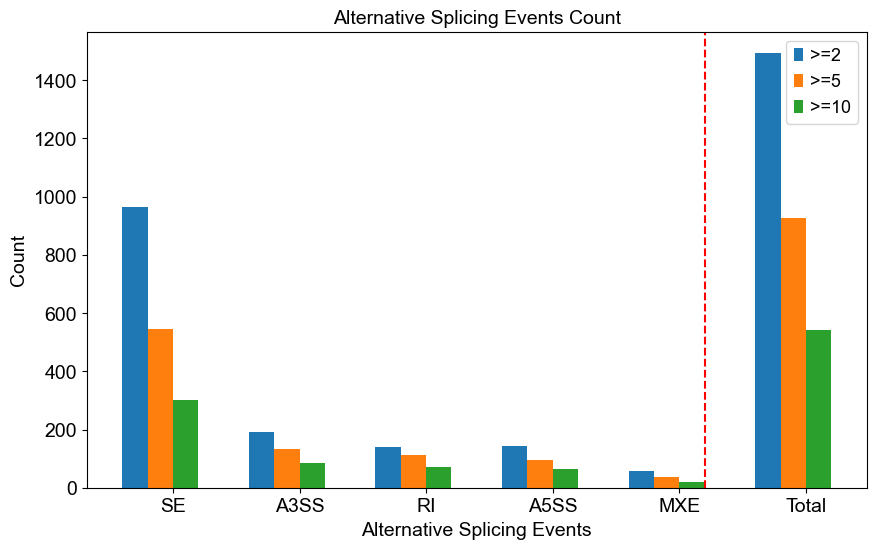

In [28]:
counts = {'SE': [], 'MXE': [], 'A3SS': [], 'A5SS': [], 'RI': []}
for key, df in tvsn_rmatsresult.items():
    df['Splice-junction-spanning read counts'] = df['IJC_SAMPLE_1'] + df['SJC_SAMPLE_1'] + df['IJC_SAMPLE_2'] + df['SJC_SAMPLE_2']
    counts[key].append((df['Splice-junction-spanning read counts'] >= 2).sum())
    counts[key].append((df['Splice-junction-spanning read counts'] >= 5).sum())
    counts[key].append((df['Splice-junction-spanning read counts'] >= 10).sum())
counts_df = pd.DataFrame(counts).T
counts_df.columns = ['>=2', '>=5', '>=10']
counts_df['Total'] = counts_df.sum(axis=1)
counts_df = counts_df.sort_values(by='Total', ascending=False)
total_counts = counts_df[['>=2', '>=5', '>=10']].sum().tolist()
total_counts.append(float('nan'))
counts_df.loc['Total'] = total_counts

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bar_width = 0.2
index = range(len(counts_df))

for i, col in enumerate(counts_df.columns[:-1]):
    ax.bar([p + i * bar_width for p in index], counts_df[col], bar_width, color=colors[i], label=col)

ax.set_xlabel('Alternative Splicing Events')
ax.set_ylabel('Count')
ax.set_title('Alternative Splicing Events Count')
ax.set_xticks([p + 1.5 * bar_width for p in index])
ax.set_xticklabels(counts_df.index)
ax.legend()
total_index = len(counts_df) - 1
ax.axvline(x=total_index - 0.5, color='red', linestyle='--')
ax.grid(False)
# plt.savefig('/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/total_as.stat.pdf')
plt.show()

## tumor vs normal spatial plot

### plot_function

In [30]:
def spatial_isoform_se(exon_name,junction_name, gene, exon_adata, junction_adata, rna_adata, save = None, return_stat = False):
    intron = junction_adata
    adata = exon_adata
    raw_rna = rna_adata
    
    intron.obs['tmp'] = np.sum(intron[:,junction_name].X,axis = 1)
    adata.obs['tmp'] = np.sum(adata[:,exon_name].X,axis = 1)
    raw_rna.obs['tmp'] = np.sum(raw_rna[:,gene].X,axis = 1)
    
    fig,axs =plt.subplots(1,3,figsize= (30,10))
    ax = axs[0]
    sns.scatterplot(x = intron.obs['x'],y = intron.obs['y'],hue = intron.obs['cluster'],s = 20,edgecolor = None,alpha = 0.55,ax = ax,palette={'0':'#FDBF6F','1':'#A6CEE3','2':'#B15928'},rasterized = True)
    ax.scatter(intron[intron.obs['tmp']>0].obsm['spatial'][:,0],intron[intron.obs['tmp']>0].obsm['spatial'][:,1],s = 100,color = '#6A3D9A',edgecolor = 'white')  
    ax.invert_yaxis()
    ax.grid(False)
    ax.set_title(f'J:{junction_name}')
    ax = axs[1]
    sns.scatterplot(x = adata.obs['x'],y = adata.obs['y'],hue = adata.obs['cluster'],s = 20,edgecolor = None,alpha = 0.55,ax = ax,palette={'0':'#FDBF6F','1':'#A6CEE3','2':'#B15928'},rasterized = True)
    ax.scatter(adata[adata.obs['tmp']>0].obsm['spatial'][:,0],adata[adata.obs['tmp']>0].obsm['spatial'][:,1],s = 100,color = '#E31A1C',edgecolor = 'white')  
    ax.invert_yaxis()
    ax.grid(False)
    ax.set_title(f'E:{exon_name}')
    ax = axs[2]
    sc.pl.spatial(raw_rna,color = gene,spot_size = 100,cmap ='Reds',show = False, ax = ax)

    
    if save !=None:
        fig.savefig(save)
    else:
        fig.show()
        
def diffiential_as(rmatsresult, save = None, figsize= (8,5)):
    dfs = rmatsresult
    for key in dfs:
        df = dfs[key]
        df['Splice-junction-spanning read counts'] = df['IJC_SAMPLE_1'] + df['SJC_SAMPLE_1'] + df['IJC_SAMPLE_2'] + df['SJC_SAMPLE_2']
        df['type'] = key

    combined_df = pd.concat(dfs.values())
    color_map = {
        'SE': 'red',
        'MXE': 'blue',
        'A3SS': 'green',
        'A5SS': 'orange',
        'RI': 'purple'
    }
    combined_df['color'] = np.where(combined_df['FDR'] > 0.05,'gray',  combined_df['type'].map(color_map))

    plt.figure(figsize=figsize)
    for key in dfs:
        df_sub = combined_df[combined_df['type'] == key]
        df_sub_color = df_sub[df_sub['color'] != 'gray']
        df_sub_gray = df_sub[df_sub['color'] == 'gray']

        plt.scatter(
            x=df_sub_color['IncLevelDifference'],
            y=-np.log10(df_sub_color['FDR']),
            s=df_sub_color['Splice-junction-spanning read counts'] * 2,  # 调整点的大小
            c=df_sub_color['color'],
            label=key,
            alpha=0.7,rasterized = True
        )
        plt.scatter(
            x=df_sub_gray['IncLevelDifference'],
            y=-np.log10(df_sub_gray['FDR']),
            c='gray',
            s = 10,
            alpha=0.2,rasterized = True
        )
    plt.xlabel('IncLevelDifference', fontsize=12)
    plt.ylabel('-log10(FDR)', fontsize=12)
    plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Alternative Splicing Events', fontsize=14)
    
    sizes = np.linspace(combined_df[combined_df['color']!='gray']['Splice-junction-spanning read counts'].min(), combined_df[combined_df['color']!='gray']['Splice-junction-spanning read counts'].max(), 4)
    labels = [int(size) for size in sizes]  # 因为s参数是实际大小的两倍
    legend_elements = []

    for size, label in zip(sizes, labels):
        legend_elements.append(plt.scatter([], [], s=size, c='gray', label=label))

    plt.legend(handles=legend_elements, title='Read Counts', bbox_to_anchor=(1.05, 0.5), loc='center left')
    plt.grid(False)
    plt.tight_layout()
    if save != None:
        plt.savefig(save)
    else:
        plt.show()
        
def differential_bar(rmatsresult, regulated = 'up',save = None,ylim = None):
    dfs = rmatsresult
    in_counts = {'SE': 0, 'MXE': 0, 'A3SS': 0, 'A5SS': 0, 'RI': 0}
    for event_type in dfs:
        df = dfs[event_type]
        if regulated =='up':
            condition = (df['FDR'] < 0.05) & (df['IncLevelDifference'] > 0)
        elif regulated == 'down':
            condition = (df['FDR'] < 0.05) & (df['IncLevelDifference'] < 0)
        in_counts[event_type] = len(df[condition])
    categories = list(in_counts.keys())
    counts = list(in_counts.values())
    colors = ['red', 'blue', 'green', 'orange', 'purple']  # 与散点图颜色保持一致

    plt.figure(figsize=(5, 5))

    bars = plt.bar(range(len(categories)),counts,tick_label=categories,color=colors, width=0.6,alpha=0.8,edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    if ylim != None:
        plt.ylim(ylim)
    plt.xlabel('Alternative Splicing Types', fontsize=14, labelpad=15)
    plt.ylabel('Differential Events Count', fontsize=14, labelpad=15)
    plt.title('Quantification of specific Splicing Events (FDR<0.05)', fontsize=16, pad=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().set_axisbelow(True)  
    plt.tight_layout()
    plt.grid(False)
    if save!= None:
        plt.savefig(save)
    else:
        plt.show()

def as_hm_plot(total_df_row, intron, exon, rna, rmatsresult , ri_adata = None, as_type = 'SE', cmap = 'flare_r', save = None):

    ######## only tumor and normal ##############
    # intron.obs['J'] = np.sum(intron[:,junction_name].X,axis = 1)
    # junction_mean_expression = intron.obs[['J','t_or_n']].groupby('t_or_n',observed = False).mean()

    # exon.obs['E'] = np.sum(exon[:,exon_name].X,axis = 1)
    # exon_mean_expression = exon.obs[['E','t_or_n']].groupby('t_or_n',observed = False).mean()

    # rna.obs['G'] = np.sum(rna[:,gene].X,axis = 1)
    # gene_mean_expression = rna.obs[['G','t_or_n']].groupby('t_or_n',observed = False).mean()

    # as_type = 'SE'
    # subtumor = rmatsresult[as_type][rmatsresult[as_type]['tran_id'] == tran_id]
    # normal = subtumor['IncLevel1'].iloc[0]
    # tumor = subtumor['IncLevel2'].iloc[0]
    # psi = pd.DataFrame({'P':[normal,tumor]},index=['normal','tumor'])
    ##############################################
    tran_id, gene, _, exon_name, _, count, _,junction_name = total_df_row


    if as_type == 'SE' or as_type == 'A3SS' or as_type == 'A5SS':
        intron.obs['J'] = np.sum(intron[:,junction_name].X,axis = 1)
        junction_mean_expression = intron.obs[['J','cluster']].groupby('cluster',observed = False).mean()

        exon.obs['E'] = np.sum(exon[:,exon_name].X,axis = 1)
        exon_mean_expression = exon.obs[['E','cluster']].groupby('cluster',observed = False).mean()

        df1 = junction_mean_expression
        df2 = exon_mean_expression

    elif as_type == 'MXE':
        chrom,strand,exon1,exon2 = exon_name.split('@')
        exon1 = chrom+'@'+strand + '@'+exon1
        exon2 = chrom+'@'+strand + '@'+exon2

        exon.obs['E1'] = np.sum(exon[:,exon1].X,axis = 1)
        exon_mean_expression_1 = exon.obs[['E1','cluster']].groupby('cluster',observed = False).mean()

        exon.obs['E2'] = np.sum(exon[:,exon2].X,axis = 1)
        exon_mean_expression_2 = exon.obs[['E2','cluster']].groupby('cluster',observed = False).mean()

        df1 = exon_mean_expression_1
        df2 = exon_mean_expression_2

    elif as_type == 'RI':
        intron.obs['J'] = np.sum(intron[:, ].X,axis = 1)
        junction_mean_expression = intron.obs[['J','cluster']].groupby('cluster',observed = False).mean()

        ri_adata.obs['R'] = np.sum(ri_adata[:,junction_name].X,axis = 1)
        ri_mean_expression = ri_adata.obs[['R','cluster']].groupby('cluster',observed = False).mean()

        df1 = junction_mean_expression
        df2 = ri_mean_expression

    rna.obs['G'] = np.sum(rna[:,gene].X,axis = 1)
    gene_mean_expression = rna.obs[['G','cluster']].groupby('cluster',observed = False).mean()

    subtumor = subclone_rmatsresult_total[as_type][subclone_rmatsresult_total[as_type]['tran_id'] == tran_id]
    tumor1 = subtumor['IncLevel1'].iloc[0]
    tumor2 = subtumor['IncLevel2'].iloc[0]
    tumorvstumor = tvsn_rmatsresult_total[as_type][tvsn_rmatsresult_total[as_type]['tran_id'] == tran_id]
    normal = tumorvstumor['IncLevel1'].iloc[0]
    psi = pd.DataFrame({'P':[normal,tumor1,tumor2]},index=['0','1','2'])

    hmdf = pd.concat([df1,df2,gene_mean_expression,psi],axis = 1)

    g = sns.clustermap(hmdf, row_cluster=False, col_cluster=False,z_score=1, figsize=(3,3),cmap = cmap)
    g.ax_heatmap.grid(False)
    g.ax_heatmap.set_title(gene)
    if save != None:
        plt.savefig(save)
    else:
        plt.show()

### filter_as for sashimi

In [36]:
for itype in ['SE','MXE','A3SS','A5SS']:
    df_sub = tvsn_rmatsresult[itype]
    df_sub = df_sub.sort_values('Splice-junction-spanning read counts',ascending = False)
    df_sub[df_sub['Splice-junction-spanning read counts']>=20].to_csv(f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/tumor_normal_dup_rmats/sashimi.{itype.lower()}.txt',sep = '\t', index=None)

### Figure plot  tumor Vs normal

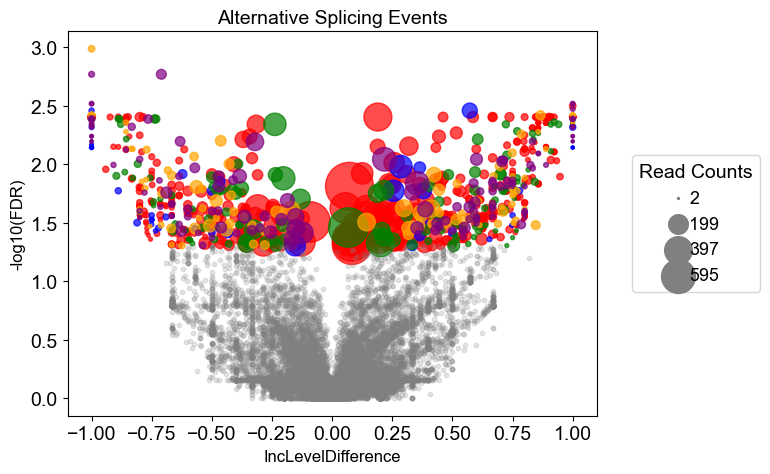

In [31]:
diffiential_as(tvsn_rmatsresult_total)# save = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/tumor_vs_normal.diffiential.pdf')

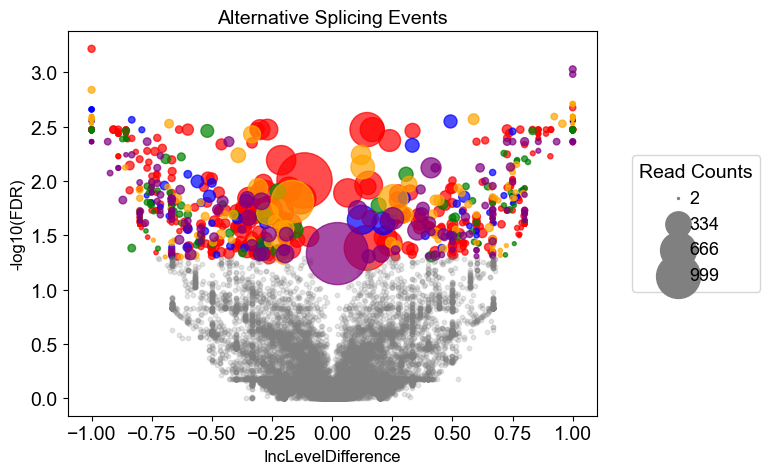

In [32]:
diffiential_as(subclone_rmatsresult_total)#save = '/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/subclone.diffiential.pdf',figsize = (7,5))

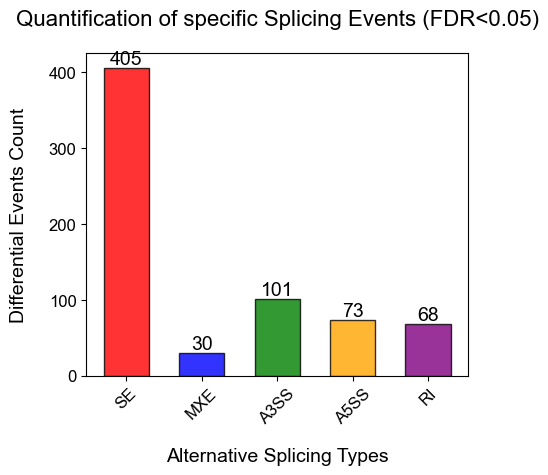

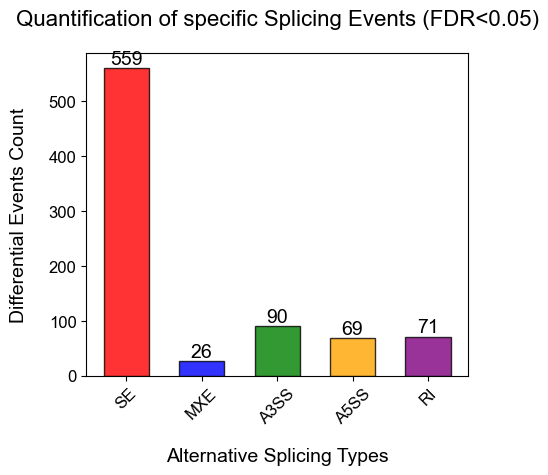

In [33]:
differential_bar(tvsn_rmatsresult_total,regulated = 'down')#save = "/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/tumor_vs_normal.down.pdf",ylim = (0,600))
differential_bar(tvsn_rmatsresult_total,regulated = 'up')#save = "/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/tumor_vs_normal.up.pdf",ylim = (0,600))

In [34]:
tvsn_total_df[tvsn_total_df['geneSymbol'] == 'GIPC1']

,tran_id,geneSymbol,IncLevelDifference,exon,type,Splice-junction-spanning read counts,junction_reads,juntion_read
1609,chr19:14496036:14496052:-@chr19:14492856:14492...,GIPC1,0.389,chr19@-@14492856_14492912,SE,72,"[chr19:14491743:14492856-, chr19:14492912:1449...",chr19:14491743:14496036-


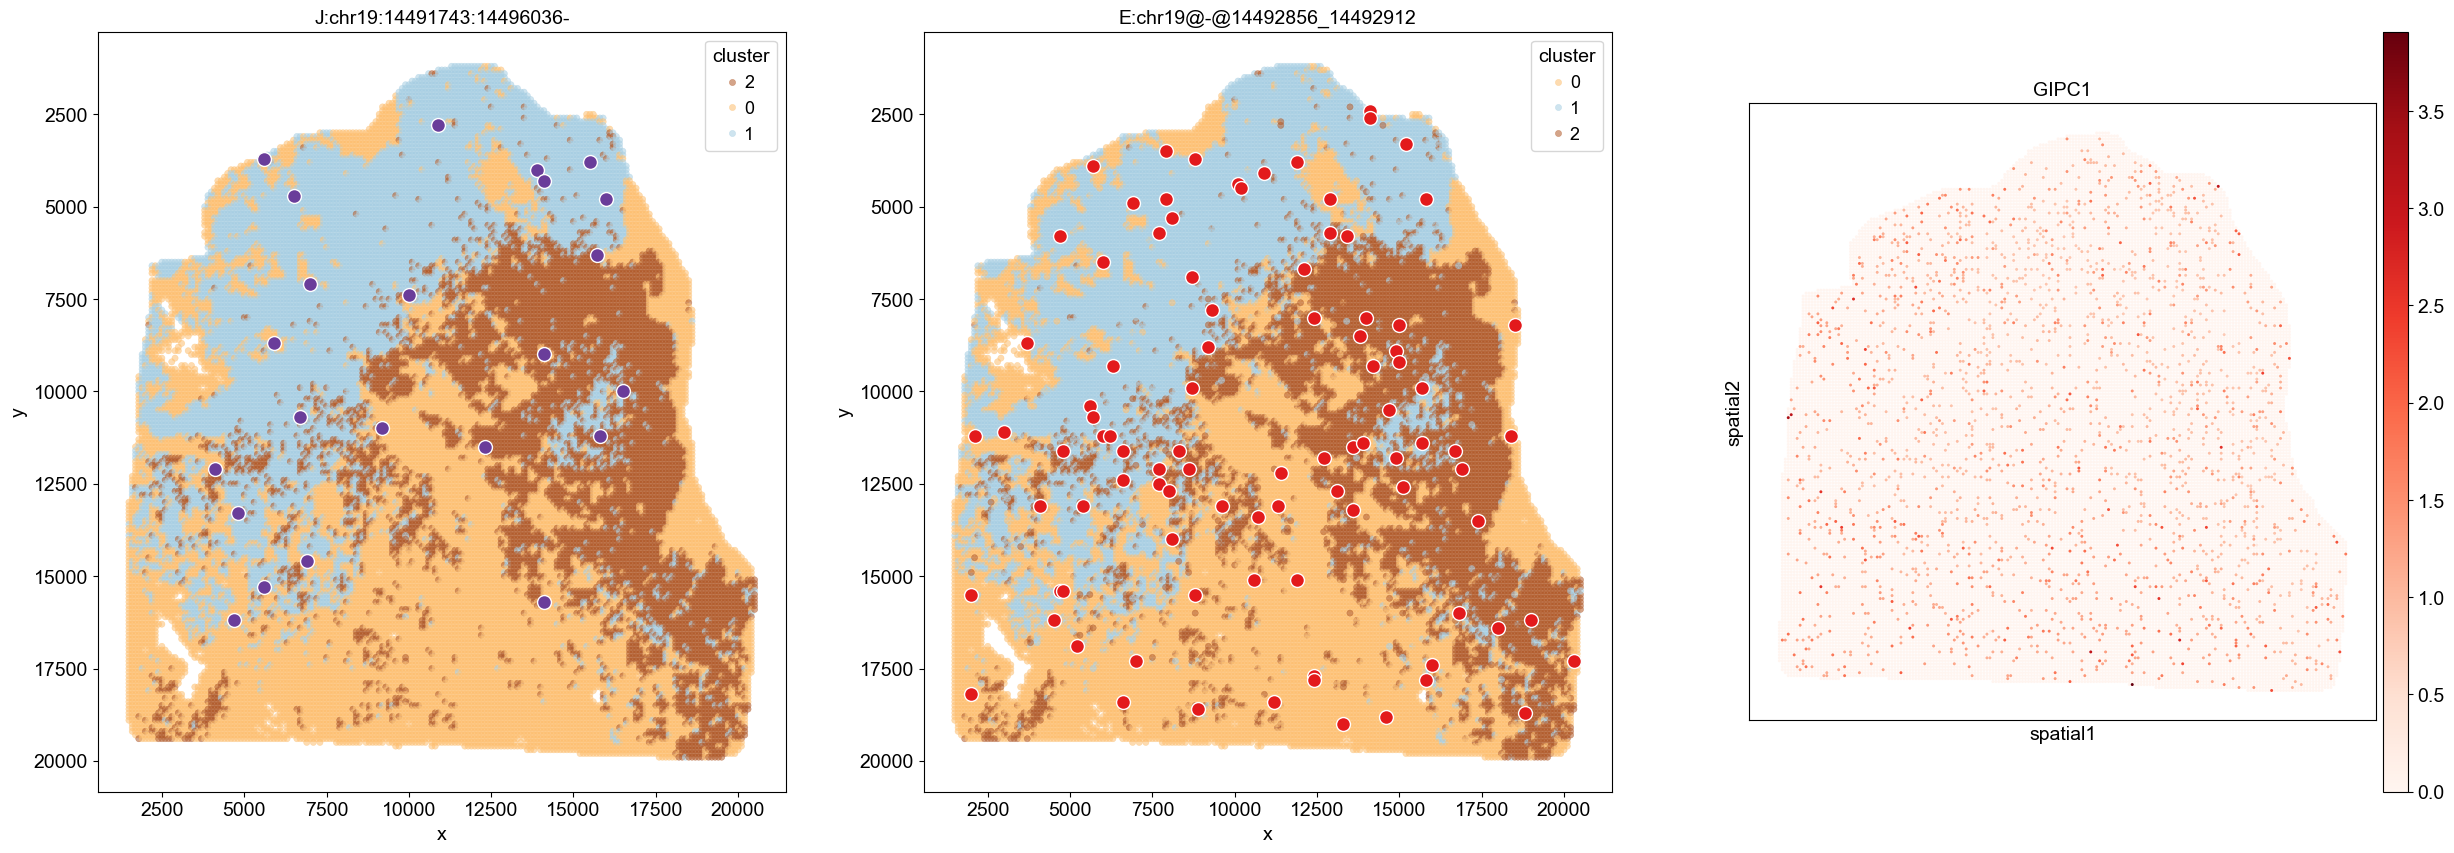

In [35]:
exon_name = 'chr19@-@14492856_14492912'
junction_name = 'chr19:14491743:14496036-'
gene = 'GIPC1'
spatial_isoform_se(exon_name,junction_name,gene,exon_adata = tvsn_exon, junction_adata= tvsn_intron, rna_adata = raw_rna)

In [47]:
sub_total_df = tvsn_total_df[tvsn_total_df['type'] == 'SE'].sort_values('Splice-junction-spanning read counts',ascending = False)
# sub_total_df = sub_total_df[ (sub_total_df['IncLevelDifference'].map(np.abs)>= 0.6) ]

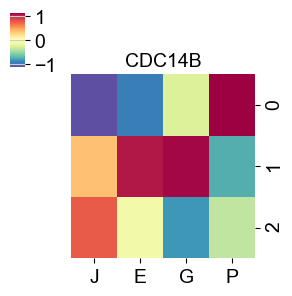

In [49]:
as_hm_plot(total_df_row = sub_total_df[sub_total_df['geneSymbol'] == 'CDC14B'].iloc[0], intron = tvsn_intron, exon = tvsn_exon, rna = raw_rna, rmatsresult = tvsn_rmatsresult, as_type = 'SE',cmap = 'Spectral_r',)
          #save = f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/CDC14B.example.pdf')

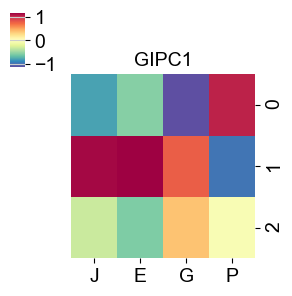

In [50]:
sub_total_df = tvsn_total_df[tvsn_total_df['type'] == 'SE'].sort_values('Splice-junction-spanning read counts',ascending = False)
as_hm_plot(total_df_row = sub_total_df[sub_total_df['geneSymbol'] == 'GIPC1'].iloc[0], intron = tvsn_intron, exon = tvsn_exon, rna = raw_rna, rmatsresult = tvsn_rmatsresult, as_type = 'SE',cmap = 'Spectral_r',)
          #save = f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/GIPC1.example.pdf')

In [52]:
sub_total_df = tvsn_total_df[tvsn_total_df['type'] == 'MXE'].sort_values('Splice-junction-spanning read counts',ascending = False)
sub_total_df = sub_total_df[ (sub_total_df['IncLevelDifference'].map(np.abs)>= 0.6) ]

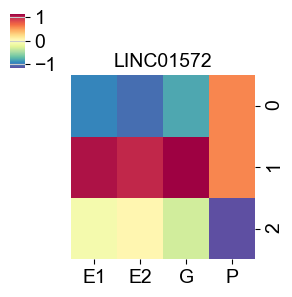

In [53]:

as_hm_plot(total_df_row = sub_total_df[sub_total_df['geneSymbol'] == 'LINC01572'].iloc[0], intron = tvsn_intron, exon = tvsn_exon, rna = raw_rna, rmatsresult = tvsn_rmatsresult, as_type = 'MXE',cmap = 'Spectral_r',)
                  # save = f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/LINC01572.example.pdf')

In [54]:
sub_total_df = tvsn_total_df[tvsn_total_df['type'] == 'A3SS'].sort_values('Splice-junction-spanning read counts',ascending = False)
sub_total_df = sub_total_df[ (sub_total_df['IncLevelDifference'].map(np.abs)>= 0.4) ]

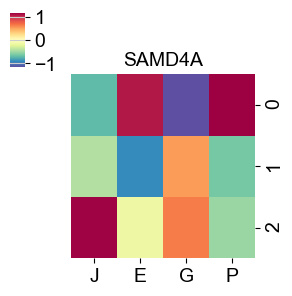

In [55]:
as_hm_plot(total_df_row = sub_total_df[sub_total_df['geneSymbol'] == 'SAMD4A'].iloc[0], intron = tvsn_intron, exon = tvsn_exon, rna = raw_rna, rmatsresult = tvsn_rmatsresult, as_type = 'A3SS',cmap = 'Spectral_r',)
#           save = f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/SAMD4A.example.pdf')

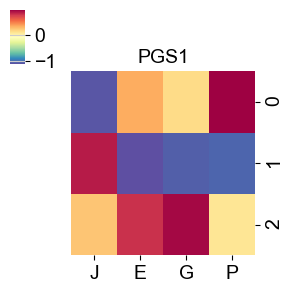

In [56]:
as_hm_plot(total_df_row = sub_total_df[sub_total_df['geneSymbol'] == 'PGS1'].iloc[0], intron = tvsn_intron, exon = tvsn_exon, rna = raw_rna, rmatsresult = tvsn_rmatsresult, as_type = 'A3SS',cmap = 'Spectral_r',)
#           save = f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/PGS1.example.pdf')

In [57]:
sub_total_df = tvsn_total_df[tvsn_total_df['type'] == 'A5SS'].sort_values('Splice-junction-spanning read counts',ascending = False)
sub_total_df = sub_total_df[ (sub_total_df['IncLevelDifference'].map(np.abs)>= 0.4) ]

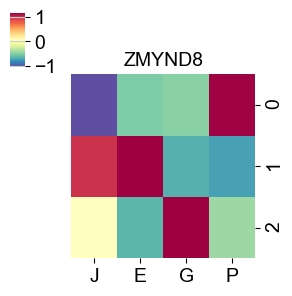

In [58]:
as_hm_plot(total_df_row = sub_total_df[sub_total_df['geneSymbol'] == 'ZMYND8'].iloc[0], intron = tvsn_intron, exon = tvsn_exon, rna = raw_rna, rmatsresult = tvsn_rmatsresult, as_type = 'A5SS',cmap = 'Spectral_r',)
#           save = f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/ZMYND8.example.pdf')

In [59]:
sub_total_df = tvsn_total_df[tvsn_total_df['type'] == 'RI'].sort_values('Splice-junction-spanning read counts',ascending = False)
sub_total_df = sub_total_df[ (sub_total_df['IncLevelDifference'].map(np.abs)>= 0.4) ]

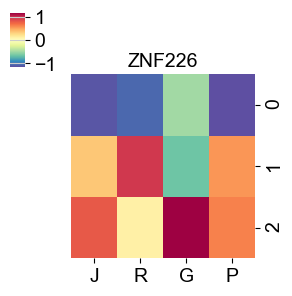

In [60]:
as_hm_plot(total_df_row = sub_total_df[sub_total_df['geneSymbol'] == 'ZNF226'].iloc[0], intron = tvsn_intron, exon = tvsn_exon, rna = raw_rna, ri_adata = tvsn_ri_adata ,rmatsresult = tvsn_rmatsresult, as_type = 'RI',cmap = 'Spectral_r')
#           save = f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/ZNF226.example.pdf')

<Axes: ylabel='Splice-junction-spanning read counts'>

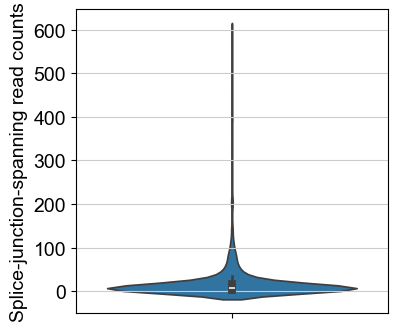

In [61]:
sns.violinplot(data = tvsn_total_df, y = 'Splice-junction-spanning read counts')
# plt.savefig(f'/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/support.pdf')

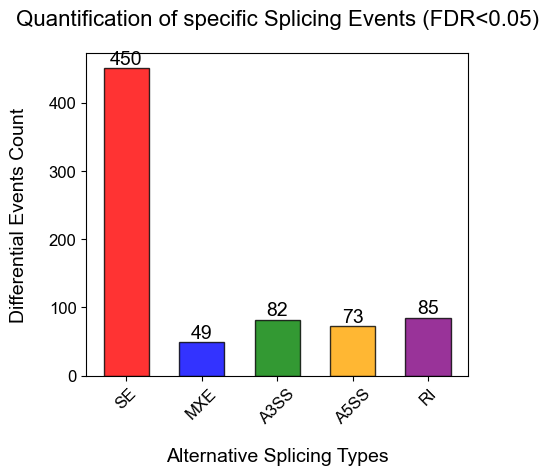

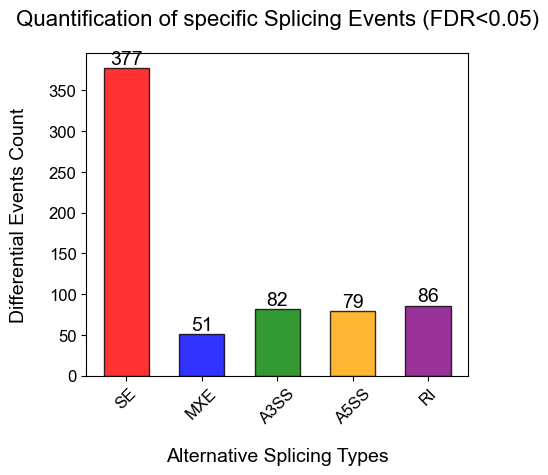

In [62]:
differential_bar(subclone_rmatsresult_total,regulated = 'down')#save = "/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/subclone.down.pdf",ylim = (0,480))
differential_bar(subclone_rmatsresult_total,regulated = 'up')#save = "/storage/liuyi/08.stereo_v2/HER2_breast/bam/as_figure_plot/subclone.up.pdf",ylim = (0,480))

In [63]:
t = 0
for i in ['SE','MXE','A3SS','A5SS','RI']:
    print(tvsn_rmatsresult[i].shape[0])

964
56
191
142
139
